In [ ]:
#####################
## Bitcoin (BTC)   ##
#####################

In [6]:
!pip install pyts
!pip install tensorflow
!pip install numpy
!pip install pandas

In [7]:
#################
### Libraries ###
#################

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from pyts.image import GramianAngularField, MarkovTransitionField
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, RMSprop


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
# Set 3 seeds and record the model performance for each : 42, 45, 91
# Best seed 42
tf.random.set_seed(45)
np.random.seed(45)

In [11]:
#################
###   Data    ###
#################

bitcoin = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BTC_noscale.csv')
bitcoin.drop(columns=['Crypto', 'Open', 'High', 'Low'], inplace=True)
bitcoin.head()

,Date,Close
0,2018-01-01,13535.0
1,2018-01-02,14770.0
2,2018-01-03,15057.0
3,2018-01-04,14921.0
4,2018-01-05,16828.0


In [26]:
########################
#### Input GAF/MTF  ####
########################

btc = bitcoin.iloc[:]

# ------------
# Parameters
# ------------
window_size = 224     # timesteps per sample
image_size = 224      # size for GAF/MTF images
train_ratio = 0.65    # training ratio
val_ratio = 0.10      # validation ratio


# -----------------------
# Step 1 — Normalisation
# -----------------------
scaler = MinMaxScaler(feature_range=(0, 1))
btc['close_scaled'] = scaler.fit_transform(btc[['Close']])

# ---------------------------------
# Step 2 — Generate sliding windows
# ---------------------------------
def create_sequences(series, window_size):
    X_seq = []
    y = []
    for i in range(len(series) - window_size):
        X_seq.append(series[i:i+window_size])
        y.append(series[i+window_size])  # predict next value
    return np.array(X_seq), np.array(y)

X_seq, y = create_sequences(btc['close_scaled'].values, window_size)

# ---------------------------------
# Step 3 — GAF & MTF for CNN branch
# ---------------------------------
gasf = GramianAngularField(image_size=image_size, method='summation')
gadf = GramianAngularField(image_size=image_size, method='difference')
mtf = MarkovTransitionField(image_size=image_size)

# Apply transforms to each sequence
X_gasf = gasf.fit_transform(X_seq)
X_gadf = gadf.fit_transform(X_seq)
X_mtf = mtf.fit_transform(X_seq)

# Stack into channels: (samples, H, W, 3)
X_cnn = np.stack((X_gasf, X_gadf, X_mtf), axis=-1)

# --------------------------
# Step 4 — LSTM branch input
# --------------------------
# LSTM expects shape: (samples, timesteps, features)
X_lstm = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))


In [27]:
# -------------------------------
# Step 5 — Train/Test split
# -------------------------------
n_samples = len(X_seq)
train_end = int(n_samples * train_ratio)
val_end = train_end + int(n_samples * val_ratio)

X_cnn_train, X_cnn_val, X_cnn_test = X_cnn[:train_end], X_cnn[train_end:val_end], X_cnn[val_end:]
X_lstm_train, X_lstm_val, X_lstm_test = X_lstm[:train_end], X_lstm[train_end:val_end], X_lstm[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

# -------------------
# Shapes check
# -------------------
print("CNN train shape:", X_cnn_train.shape)   # (samples, H, W, 3)
print("LSTM train shape:", X_lstm_train.shape) # (samples, timesteps, 1)
print("Targets train shape:", y_train.shape)

CNN train shape: (1139, 224, 224, 3)
LSTM train shape: (1139, 224, 1)
Targets train shape: (1139,)


In [14]:
################
##### CNN  #####
################

# ------------------------
# Step 1 — Build Input CNN
# ------------------------
cnn_input = Input(shape=(224, 224, 3))
dropout_rate = 0.29145153405423596
activation_func = 'relu'

# --------------------------------------------
# Step 2 — Build VGG16 Model (pre-trained CNN)
# --------------------------------------------

vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)


# ----------------------------------
# Step 3 — Convolution/Pooling/Dense
# ----------------------------------

# Conv2D 128-64, Flatten, Dense(128)
x = vgg(cnn_input)
x = layers.Conv2D(128, (2, 2), activation=activation_func)(x)
x = layers.Conv2D(64, (2, 2), activation=activation_func)(x)
x = layers.Flatten()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(128, activation=activation_func)(x)
cnn_out = x

# ---------------------------
# Step 4 — Input LSTM
# ---------------------------

# Parameters
act_func = 'tanh'
n_timesteps = X_lstm_train.shape[1]
n_features = X_lstm_train.shape[2]

# ---------------------------
# Step 5 — LSTM structure
# ---------------------------

lstm_input = Input(shape=(n_timesteps,n_features))
y = LSTM(64, return_sequences=True, activation='tanh')(lstm_input)
y = LSTM(16, return_sequences=True, activation='tanh')(y)
y = LSTM(2, return_sequences=False, activation='tanh')(y)
lstm_out = y

# ---------------------------
# Step 6 — Concated O/P
# ---------------------------
combined = Concatenate()([cnn_out, lstm_out])
output = Dense(1, activation='linear')(combined)


# ----------------------------------
# Step 7 — Compile Model/Regression
# ----------------------------------
optimizer_func = RMSprop(learning_rate=0.0004047368844376192)
model = Model(inputs=[cnn_input, lstm_input], outputs=output)
model.compile(loss='mean_squared_error', optimizer=optimizer_func, metrics=['mae', RootMeanSquaredError(), 'mape'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [15]:
# --------------------
# Step 8 — Training
# --------------------

history = model.fit([X_cnn_train, X_lstm_train], y_train,
                   epochs=150, batch_size=64,
                   validation_data=([X_cnn_val, X_lstm_val], y_val),
                   verbose=2)

Epoch 1/150
19/19 - 25s - 1s/step - loss: 61.2969 - mae: 2.2217 - mape: 263655.9062 - root_mean_squared_error: 7.8292 - val_loss: 0.1107 - val_mae: 0.3261 - val_mape: 52.5938 - val_root_mean_squared_error: 0.3327
Epoch 2/150
19/19 - 3s - 133ms/step - loss: 0.0866 - mae: 0.2395 - mape: 119120.5391 - root_mean_squared_error: 0.2943 - val_loss: 0.1113 - val_mae: 0.3267 - val_mape: 52.6793 - val_root_mean_squared_error: 0.3336
Epoch 3/150
19/19 - 3s - 132ms/step - loss: 0.0992 - mae: 0.2497 - mape: 195183.6562 - root_mean_squared_error: 0.3150 - val_loss: 0.3072 - val_mae: 0.5505 - val_mape: 89.6292 - val_root_mean_squared_error: 0.5542
Epoch 4/150
19/19 - 3s - 132ms/step - loss: 0.0980 - mae: 0.2450 - mape: 298665.0625 - root_mean_squared_error: 0.3131 - val_loss: 0.1043 - val_mae: 0.3156 - val_mape: 50.8440 - val_root_mean_squared_error: 0.3229
Epoch 5/150
19/19 - 3s - 133ms/step - loss: 0.0774 - mae: 0.2238 - mape: 201000.9219 - root_mean_squared_error: 0.2782 - val_loss: 0.1110 - val_m

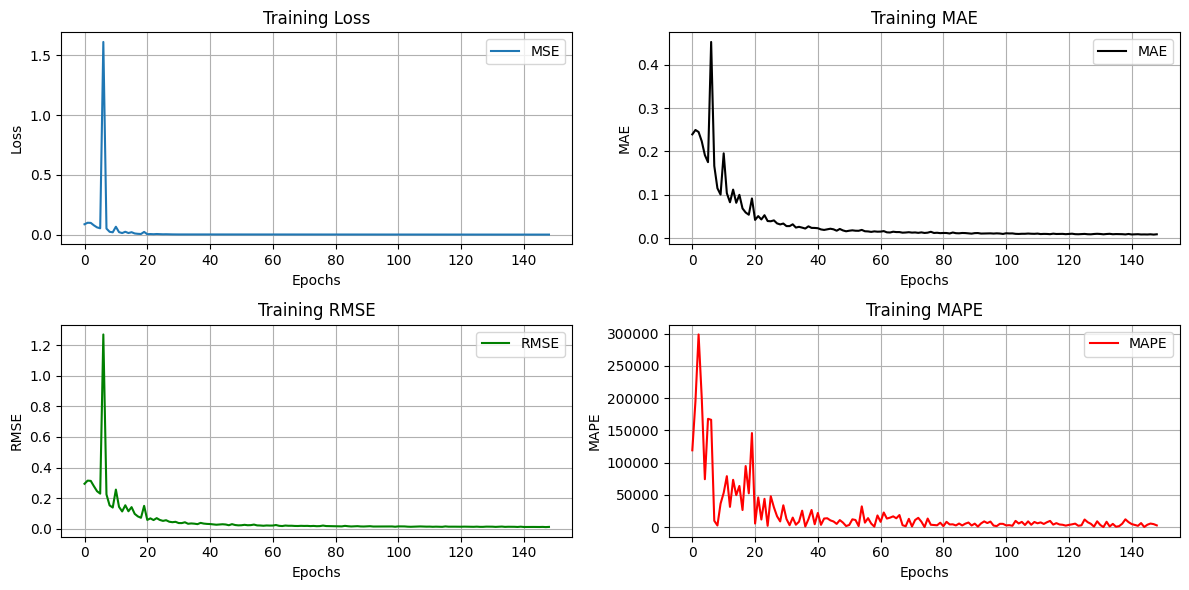

In [18]:
####################
### Plot Results ###
####################

# Training MSE
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].plot(history.history['loss'][1:], label='MSE')
ax[0, 0].set_title('Training Loss')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()
ax[0,0].grid(True)

# Training MAE
ax[0, 1].plot(history.history['mae'][1:], label='MAE', color='black')
ax[0, 1].set_title('Training MAE')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('MAE')
ax[0, 1].legend()
ax[0,1].grid(True)

# Training RMSE
ax[1, 0].plot(history.history['root_mean_squared_error'][1:], label='RMSE', color='green')
ax[1, 0].set_title('Training RMSE')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('RMSE')
ax[1, 0].legend()
ax[1,0].grid(True)

# Training MAPE
ax[1, 1].plot(history.history['mape'][1:], label='MAPE', color='red')
ax[1, 1].set_title('Training MAPE')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('MAPE')
ax[1, 1].legend()
ax[1,1].grid(True)

plt.tight_layout()
plt.show()

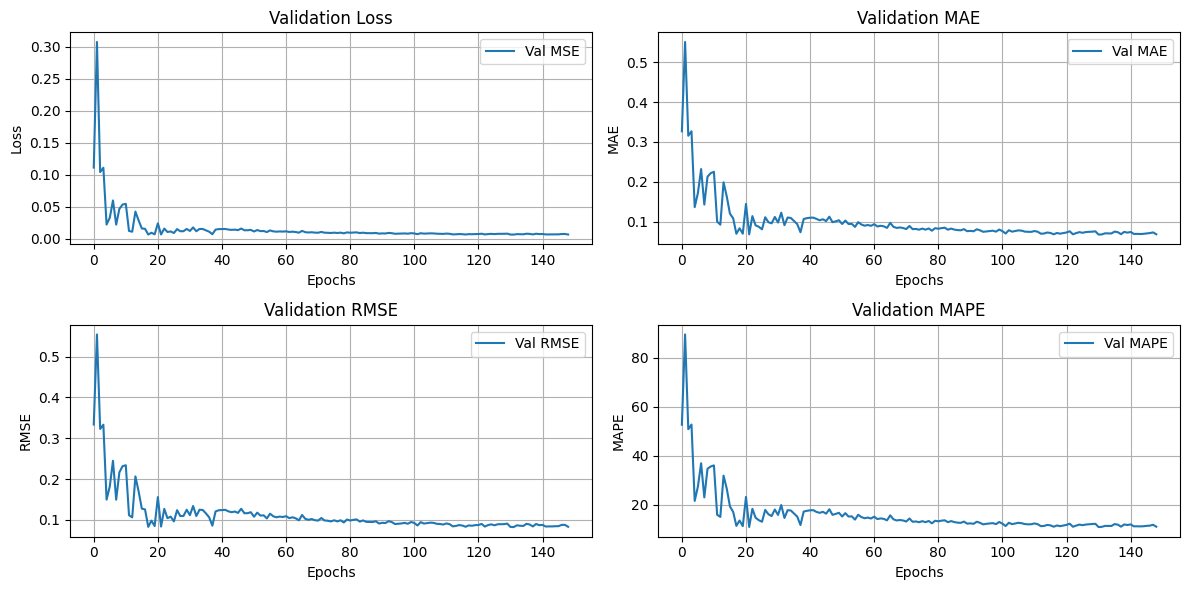

In [19]:
# Validation MSE
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].plot(history.history['val_loss'][1:], label='Val MSE')
ax[0, 0].set_title('Validation Loss')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()
ax[0,0].grid(True)

# Validation MAE
ax[0, 1].plot(history.history['val_mae'][1:], label='Val MAE')
ax[0, 1].set_title('Validation MAE')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('MAE')
ax[0, 1].legend()
ax[0,1].grid(True)

# Validation RMSE
ax[1, 0].plot(history.history['val_root_mean_squared_error'][1:], label='Val RMSE')
ax[1, 0].set_title('Validation RMSE')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('RMSE')
ax[1, 0].legend()
ax[1,0].grid(True)


# Validation MAPE
ax[1, 1].plot(history.history['val_mape'][1:], label='Val MAPE')
ax[1, 1].set_title('Validation MAPE')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('MAPE')
ax[1, 1].legend()
ax[1,1].grid(True)

plt.tight_layout()
plt.show()

In [20]:
# Store best training/validation metrics
# Training
train_mse = history.history['loss']
best_epoch = np.argmin(train_mse)
best_train_mse = train_mse[best_epoch]
best_train_rmse = history.history['root_mean_squared_error'][best_epoch]
best_train_mae  = history.history['mae'][best_epoch]
best_train_mape = history.history['mape'][best_epoch]

# Validation: record epoch at which validation loss is the lowest for each seed
val_mse = history.history['val_loss']
best_epoch = np.argmin(val_mse)
best_val_mse = val_mse[best_epoch]
best_val_rmse = history.history['val_root_mean_squared_error'][best_epoch]
best_val_mae  = history.history['val_mae'][best_epoch]
best_val_mape = history.history['val_mape'][best_epoch]

In [16]:
# -------------------------
# Step 9 — Predict/Testing
# -------------------------

y_predict= model.predict([X_cnn_test, X_lstm_test])

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


In [17]:
# -----------------------------------
# Step 10 — Test MSE/RMSE/MAE/MAPE/R2
# -----------------------------------

# Compute the loss metrics
test_mse = mean_squared_error(y_test, y_predict)
test_rmse = root_mean_squared_error(y_test, y_predict)
test_mae = mean_absolute_error(y_test, y_predict)
test_mape = mean_absolute_percentage_error(y_test, y_predict)
test_r2_score = r2_score(y_test, y_predict)

print("Mean Squared Error:", test_mse)
print("Root Mean Squared Error:", test_rmse)
print("Mean Absolute Error:", test_mae)
print("Mean Absolute Percentage Error:", test_mape)
print("R2 Score:", test_r2_score)

Mean Squared Error: 0.008968164386983243
Root Mean Squared Error: 0.09470039274988908
Mean Absolute Error: 0.080286558335921
Mean Absolute Percentage Error: 0.2518985933933753
R2 Score: 0.31126006718829213


In [21]:
#-------------------------------------------------
# Step 11 - Inverse scaling: original price scale
#-------------------------------------------------

y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
y_predict_orig = scaler.inverse_transform(y_predict)

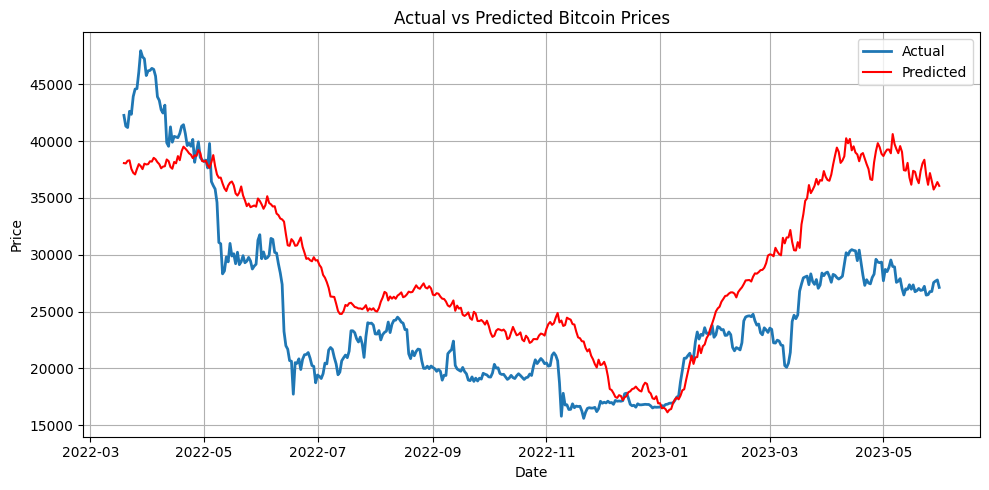

In [22]:
#----------------------------------------------
# Step 12 - Plot prediction vs. actuals prices
#----------------------------------------------

# Add window size
start_index = len(y_train)+len(y_val)+ 224

# Test set dates + convert to datetime
dates = btc['Date'].iloc[start_index:start_index + len(y_test_orig)].reset_index(drop=True)
dates = pd.to_datetime(dates)

# Plot the actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(dates, y_test_orig, label='Actual', linewidth=2)
plt.plot(dates, y_predict_orig, label='Predicted', color='red')
plt.title('Actual vs Predicted Bitcoin Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
#--------------------------
# Step 13 - Export results
#--------------------------

# Export prediction dataset
predictions_df = pd.DataFrame({
    'Date': dates,
    'Actual': y_test_orig.flatten(),
    'Predicted': y_predict_orig.flatten()
})

predictions_df.to_csv('BTC_cnn_predictions.csv', index=False)

from google.colab import files
files.download('BTC_cnn_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
# Store metrics in dataframe along with best training/validation loss (record epoch)
results = {
    "seed": 45,
    "best_epoch": best_epoch + 1,    # best validation epoch
    "train_mse": best_train_mse,
    "train_rmse": best_train_rmse,
    "train_mae": best_train_mae,
    "train_mape": best_train_mape,
    "val_mse": best_val_mse,
    "val_rmse": best_val_rmse,
    "val_mae": best_val_mae,
    "val_mape": best_val_mape,
    "test_mse": test_mse,
    "test_rmse": test_rmse,
    "test_mae": test_mae,
    "test_mape": test_mape,
    "test_r2_score": test_r2_score
}

btc_results = pd.DataFrame([results])
btc_results.to_csv('btc_results.csv')

files.download('btc_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# Export results

loss_results = pd.DataFrame(history.history)
loss_results.to_csv('loss_results.csv')

files.download('loss_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Regime Classification**

In [ ]:
# ------------------------------------------
# Step 1 — Compute Log returns & Volatility
# ------------------------------------------

original = pd.DataFrame({
    'Date': dates,
    'Actual': y_test_orig.ravel()
})

predicted = pd.DataFrame({
    'Date': dates,
    'Predicted': y_predict_orig.ravel()
})

# Compute returns from actual and predicted prices
returns_orig = original['Actual'].pct_change()
returns_pred = predicted['Predicted'].pct_change()
# Drop NaN values from returns
returns_orig = returns_orig.fillna(0)
returns_pred = returns_pred.fillna(0)

# Compute 10-day rolling volatility
volatility_orig = returns_orig.rolling(window=10).std()
volatility_pred = returns_pred.rolling(window=10).std()
volatility_orig = volatility_orig.fillna(0)
volatility_pred = volatility_pred.fillna(0)

# Update dataframes with returns and volatility
original['Returns'] = returns_orig
predicted['Returns'] = returns_pred
original['Volatility'] = volatility_orig
predicted['Volatility'] = volatility_pred


In [ ]:
# --------------------------------
# Step 2 — Label Volatility L-M-H
# --------------------------------

# Compute quantiles as thresholds for low/med/high volatility
low_threshold = volatility_orig.quantile(0.33)   # lower 33%
high_threshold = volatility_orig.quantile(0.67)  # upper 33%

# Label volatility
def label_volatility(vol):
    if vol <= low_threshold:
        return 'low'
    elif vol >= high_threshold:
        return 'high'
    else:
        return 'medium'

# Apply volatility low/medium/high to original and prediction dataset
original['Volatility_level'] = original['Volatility'].apply(label_volatility)
predicted['Volatility_level'] = predicted['Volatility'].apply(label_volatility)


In [ ]:
# -------------------------------
# Step 3 — Regime Classification
# -------------------------------

# Classify regime based on volatility + average sign of the returns
def classify_regime(pred_labels, vol_value, vol_threshold=(low_threshold, high_threshold), window=3):
    regimes = []
    low_threshold, high_threshold = vol_threshold

    for i in range(len(pred_labels) - window):
        window_preds = pred_labels[i:i+window]
        window_vol = vol_value[i+window]
        sign_pred = np.sign(window_preds.mean())

        if window_vol <= low_threshold:
            regimes.append("Neutral")

        else:
            if sign_pred > 0:
                regimes.append("Bull")
            elif sign_pred < 0:
                regimes.append("Bear")
            else:
                regimes.append("Uncertain")

    return regimes

vol_value = original['Volatility']
regimes = classify_regime(original['Returns'], vol_value)


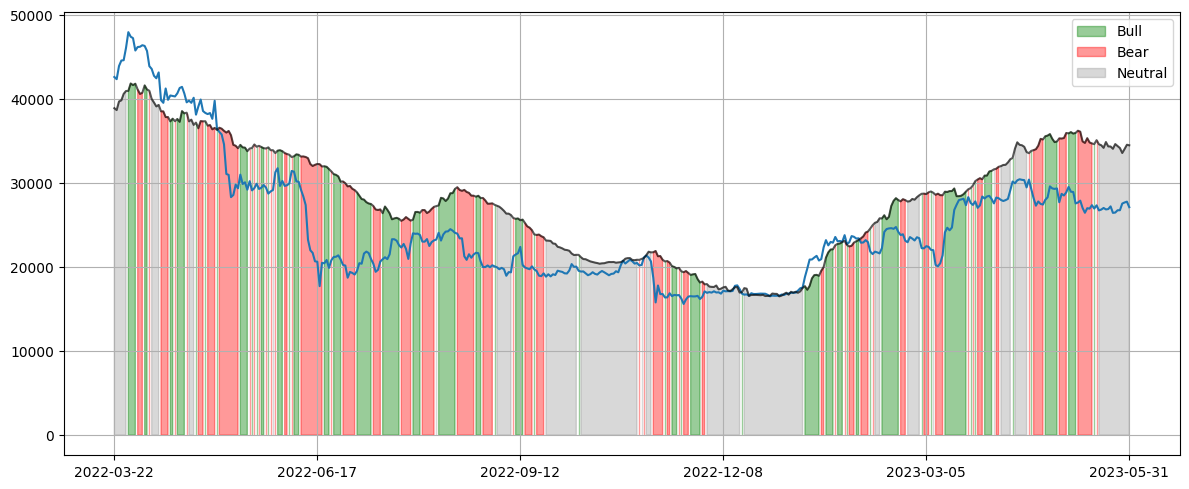

In [ ]:
####################
######  Plots ######
####################

# Plot price vs. date regime shifts in
plt.figure(figsize=(12, 5))
plt.plot(original['Date'][3:], original['Actual'][3:])
plt.plot(original['Date'][3:], predicted['Predicted'][3:], color='black', alpha=0.65)

plt.fill_between(original['Date'][3:], predicted['Predicted'][3:], where=[r == 'Bull' for r in regimes], color='green', alpha=0.4, label='Bull');
plt.fill_between(original['Date'][3:], predicted['Predicted'][3:], where=[r == 'Bear' for r in regimes], color='red', alpha=0.4, label='Bear');
plt.fill_between(original['Date'][3:], predicted['Predicted'][3:], where=[r == 'Neutral' for r in regimes], color='grey', alpha=0.3, label='Neutral');

N = len(original['Date'][3:]) // 5
xticks = original['Date'][3::N]
plt.xticks(xticks);
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


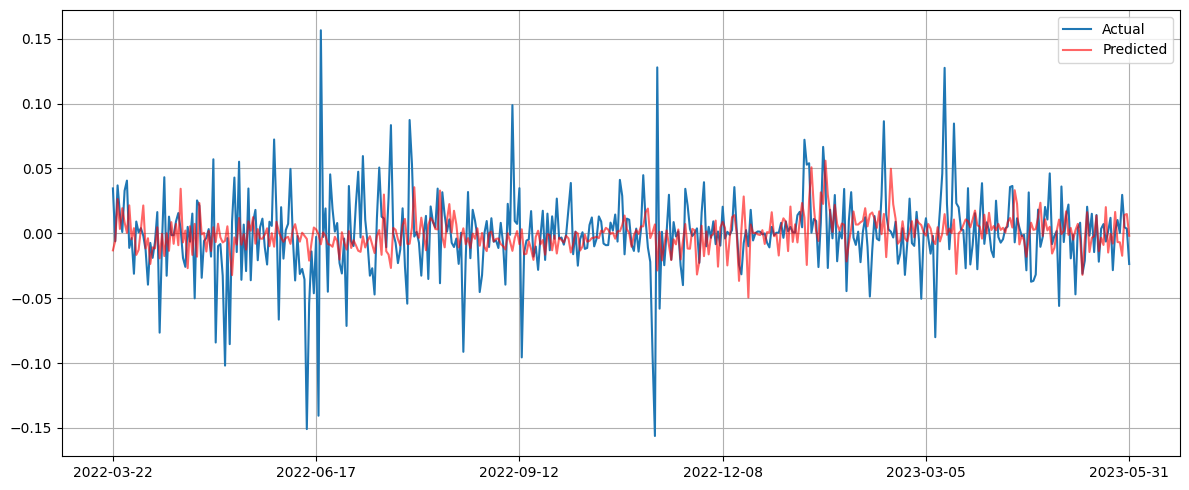

In [ ]:
# Plot regime shift for log returns vs. date
plt.figure(figsize=(12, 5))
plt.plot(original['Date'][3:], original['Returns'][3:], label='Actual')
plt.plot(original['Date'][3:], predicted['Returns'][3:], color='red', alpha=0.6, label='Predicted')

N = len(original['Date'][3:]) // 5
xticks = original['Date'][3::N]
plt.xticks(xticks);

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

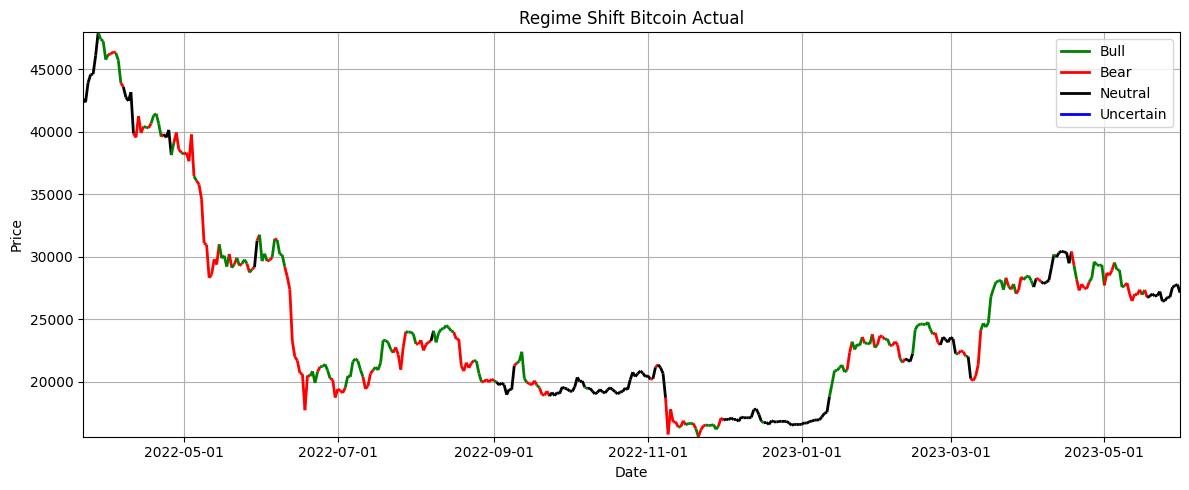

In [ ]:
# Plot price vs. date regime shift

# Select dates, prices values and convert to matplotlib format
# Plot each segment
dates = pd.to_datetime(original['Date'][3:])
prices = original['Actual'][3:].values
x = mdates.date2num(dates)
points = np.array([x, prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Map each regime to color & add legend to plot
color_map = {'Bull': 'green', 'Bear': 'red', 'Neutral': 'black', 'Uncertain':'blue'}
colors = [color_map.get(r, 'black') for r in regimes[:len(segments)]]
legend = [
    Line2D([0], [0], color='green', lw=2, label='Bull'),
    Line2D([0], [0], color='red', lw=2, label='Bear'),
    Line2D([0], [0], color='black', lw=2, label='Neutral'),
    Line2D([0], [0], color='blue', lw=2, label='Uncertain')
]


# Plot Lineplot with date range from above/legend
fig, ax = plt.subplots(figsize=(12, 5))
lc = LineCollection(segments, colors=colors, linewidth=2)
ax.add_collection(lc)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(prices.min(), prices.max())
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=0)

ax.legend(handles=legend)
ax.set_title("Regime Shift Bitcoin Actual")
ax.set_xlabel("Date")
ax.set_ylabel("Price")

plt.grid(True)
plt.tight_layout()
plt.show()

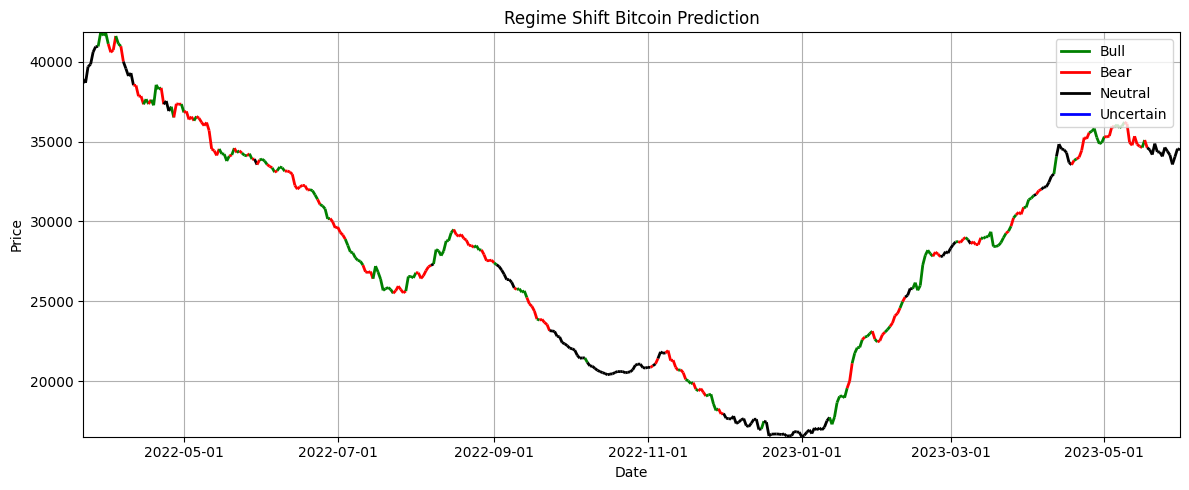

In [ ]:
# Plot price vs. date regime shift

# Select dates, prices values and convert to matplotlib format
# Plot each segment
dates = pd.to_datetime(original['Date'][3:])
prices = predicted['Predicted'][3:].values
x = mdates.date2num(dates)
points = np.array([x, prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Map each regime to color & add legend to plot
color_map = {'Bull': 'green', 'Bear': 'red', 'Neutral': 'black', 'Uncertain':'blue'}
colors = [color_map.get(r, 'black') for r in regimes[:len(segments)]]
legend = [
    Line2D([0], [0], color='green', lw=2, label='Bull'),
    Line2D([0], [0], color='red', lw=2, label='Bear'),
    Line2D([0], [0], color='black', lw=2, label='Neutral'),
    Line2D([0], [0], color='blue', lw=2, label='Uncertain')
]


# Plot Lineplot with date range from above/legend
fig, ax = plt.subplots(figsize=(12, 5))
lc = LineCollection(segments, colors=colors, linewidth=2)
ax.add_collection(lc)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(prices.min(), prices.max())
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=0)

ax.legend(handles=legend)
ax.set_title("Regime Shift Bitcoin Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Price")

plt.grid(True)
plt.tight_layout()
plt.show()